# Data Insights & Predictive Analysis

---
## Introduction

This notebook presents a comprehensive analysis of Red Pill-aligned YouTube content, combining exploratory data visualization, statistical insights, and machine learning to uncover:

### Key Focus Areas
1. **Engagement Patterns**: What drives likes, comments, and shares in this niche
2. **Content Optimization**: How video characteristics (length, titles, tags) impact performance
3. **Predictive Modeling**: Forecasting video success before publication

### Methodology Overview
- **Phase 1**: Exploratory Analysis
  - Distribution visualization (violin/box plots)
  - Temporal trend analysis
  - Sentiment scoring of titles/descriptions

- **Phase 2**: Feature Engineering
  - Composite engagement metrics
  - Content quality indicators
  - Channel-specific baselines

- **Phase 3**: Machine Learning
  - View count prediction (regression)
  - High-performer classification
  - Model interpretation (SHAP/LIME)

---
### Imports:

In [1]:
!pip install isodate nltk wordcloud

### Core Data Handling
- **pandas/numpy**: Data manipulation & numerical operations
- **time**: Measure code execution duration
- **isodate/dateutil**: Parse YouTube's ISO 8601 durations/timestamps

### Visualization
- **seaborn/matplotlib**: Create publication-quality plots
  - `sns.set()` applies professional styling
  - `ticker` customizes axis formatting

### NLP & Text Processing
- **nltk**: Natural Language Toolkit
  - `stopwords`: Filter common words (the, and, etc.)
  - `word_tokenize`: Split text into words/phrases
- **wordcloud**: Generate visual text frequency maps

In [2]:
import pandas as pd
import numpy as np
import time
import isodate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk
sns.set(style="darkgrid", color_codes=True)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bashaardhoot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Loading
- Processed datasets loaded from:
  - `cleanedDataFrame.csv`: Video metadata
  - `cleanedComments.csv`: User comments

In [3]:
video_df = pd.read_csv("dataFolder/processed/cleanedDataFrame.csv")

In [4]:
comments_df = pd.read_csv("dataFolder/processed/cleanedComments.csv")

In [7]:
comments_df

,video_id,channelTitle,comment,published_at
0,F5eSaabAAmk,Benjamin Seda,big boobs lmao,2025-03-10T00:36:43Z
1,F5eSaabAAmk,Benjamin Seda,"This will work for a specific type of woman, o...",2025-03-09T23:01:56Z
2,F5eSaabAAmk,Benjamin Seda,Can you do a video on what to do if you enco...,2025-03-09T07:13:54Z
3,F5eSaabAAmk,Benjamin Seda,God of the Dates 🤍,2025-03-08T14:57:50Z
4,F5eSaabAAmk,Benjamin Seda,"About cold approaches, it's just not true. I d...",2025-03-07T19:06:08Z
...,...,...,...,...
1079841,FirJFTPpE8M,FreshandFit,#REDPILLUP,2020-05-11T16:29:17Z
1079842,FirJFTPpE8M,FreshandFit,Nice intro. Had to sub after the livestream wi...,2020-05-09T21:35:24Z
1079843,FirJFTPpE8M,FreshandFit,🔥🔥🔥🔥🔥🔥,2020-05-09T15:27:29Z
1079844,FirJFTPpE8M,FreshandFit,"No scams or shortcuts here. Real facts, real r...",2020-05-08T18:57:41Z


*"These libraries form the foundation for EDA, feature engineering, and NLP tasks in our analysis."*

---
### Data Quality Verification

### Purpose
Identified data completeness across all columns, with only the `description` field containing null values.

### Key Findings
- **Complete Fields**: All engineered features (`durationSecs`, `tagCount`, etc.) and core metrics (`viewCount`, `likeCount`) show 0 nulls
- **Partial Nulls**:  
  - `description` column contains some null values  
  - All other columns are fully populated

In [6]:
video_df.isnull().any()

video_id                        False
channelTitle                    False
title                           False
description                      True
tags                            False
publishedAt                     False
viewCount                       False
likeCount                       False
favouriteCount                  False
commentCount                    False
duration                        False
definition                      False
caption                         False
publishDayName                  False
publishedAt_timestamp           False
tagCount                        False
durationSecs                    False
titleLength                     False
view_per_like                   False
comment_duration_interaction    False
popularity_score                False
commentRatio                    False
likeRatio                       False
title_sentiment                 False
dtype: bool

In [7]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2021-06-03 16:15:00    2
2023-03-16 20:00:05    2
2024-02-12 15:00:04    2
2023-03-14 20:00:07    2
2022-12-27 21:00:02    2
                      ..
2021-10-28 00:43:59    1
2021-10-28 04:58:45    1
2021-10-28 14:00:17    1
2021-10-28 15:27:24    1
2025-03-07 16:00:27    1
Name: count, Length: 12881, dtype: int64

### Action Taken
 **Descriptions**:  
   - Preserved null values intentionally  
   - Enables differentiation between:  
     - Videos with no description (`NaN`)  
     - Videos with empty descriptions (`""`)  

 **Validation**:  
   - Confirmed all calculated features:  
     - Contain no nulls  
     - Were computed correctly (e.g., `durationSecs=0` for invalid durations)  

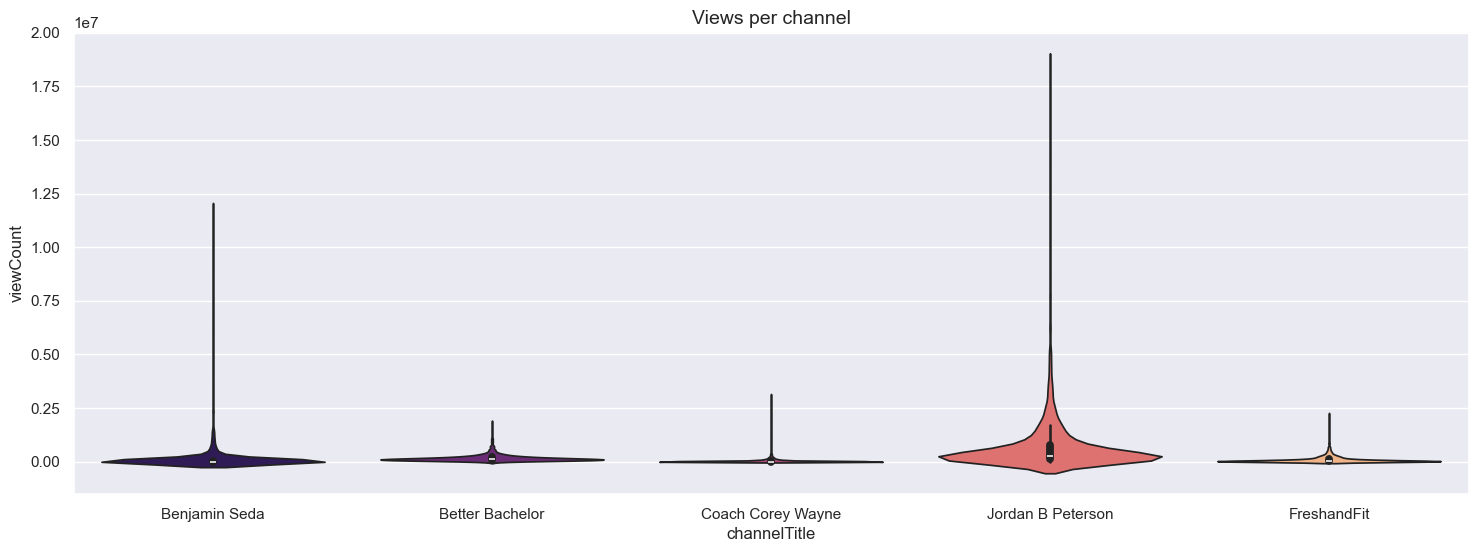

In [13]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x='channelTitle', y='viewCount', data=video_df, hue='channelTitle', palette='magma', legend=False)
plt.title('Views per channel', fontsize=14)
plt.show()

<Axes: xlabel='likeCount', ylabel='viewCount'>

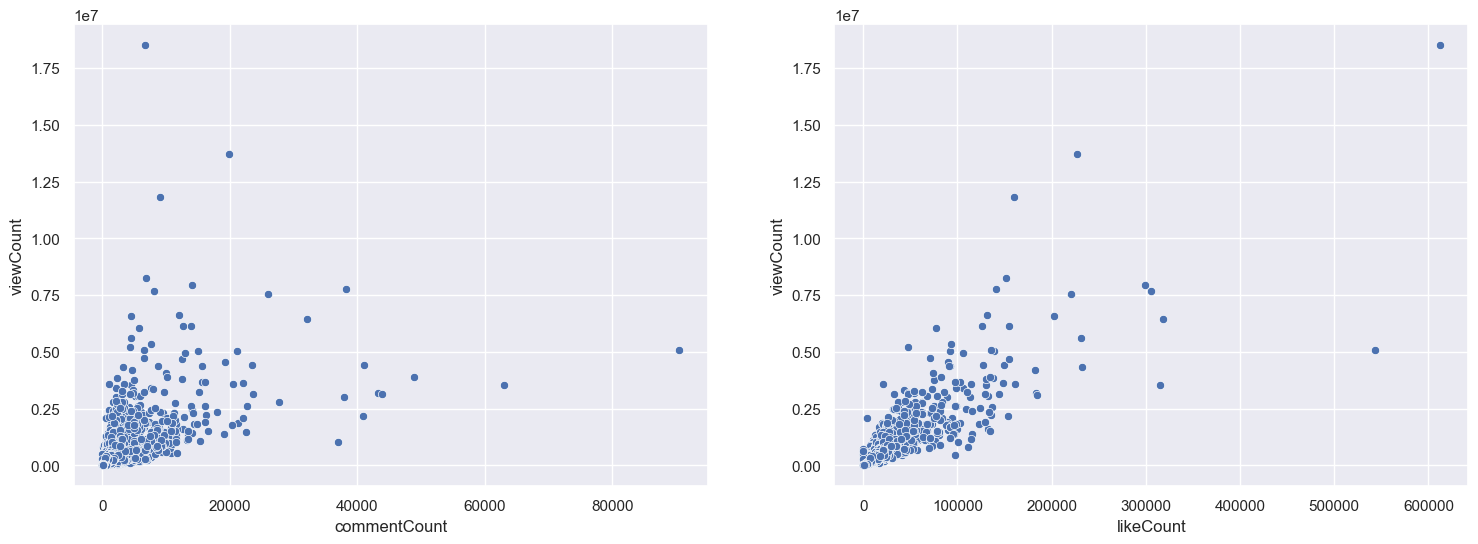

In [10]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<Axes: xlabel='likeRatio', ylabel='viewCount'>

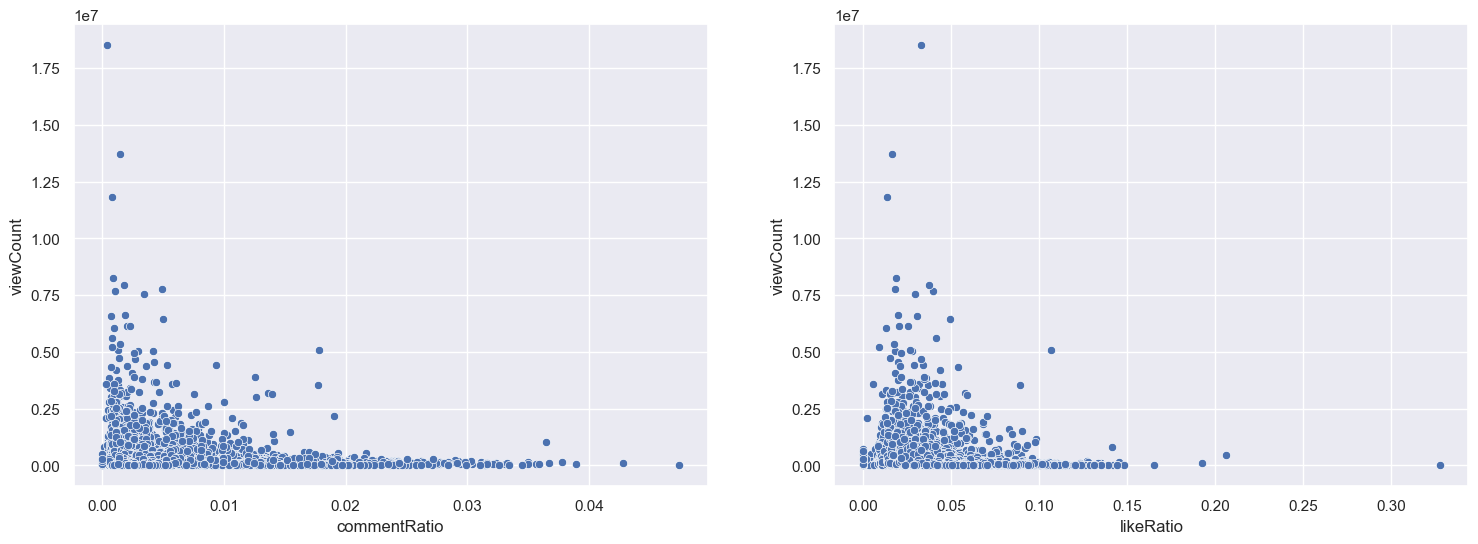

In [12]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


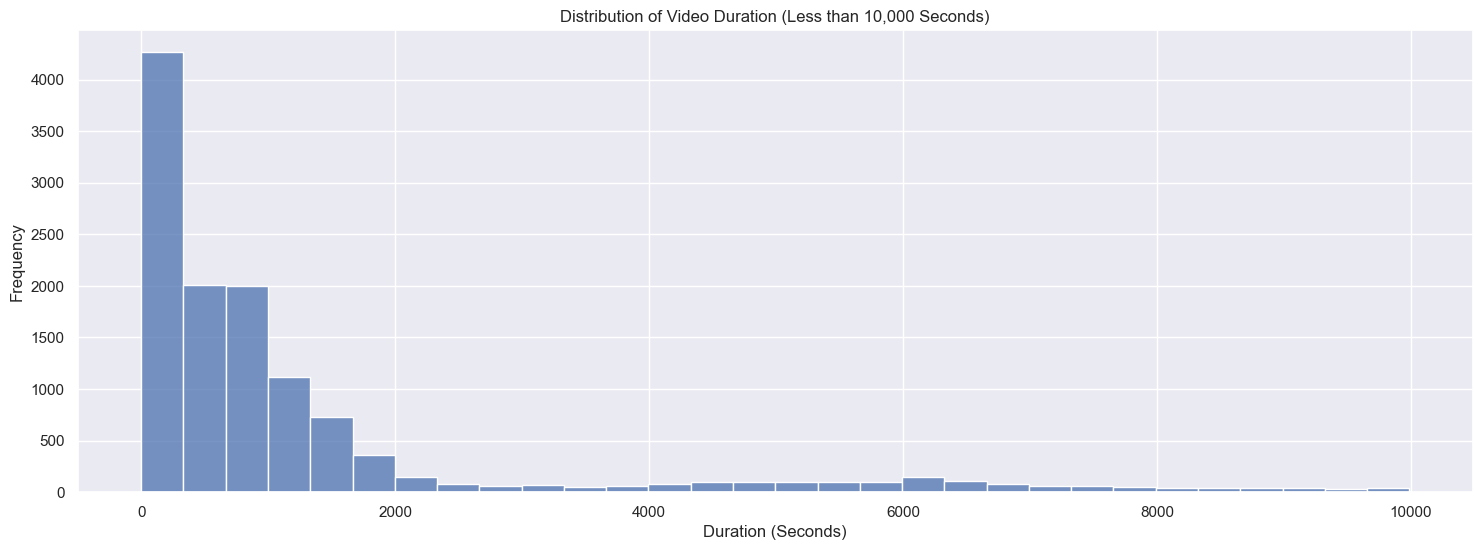

In [13]:
# Replace infinite values with NaN
video_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values (optional)
video_df.dropna(inplace=True)

# Filter videos with duration less than 10,000 seconds
filtered_df = video_df[video_df['durationSecs'] < 10000]

# Plot the histogram
sns.histplot(data=filtered_df, x="durationSecs", bins=30)
plt.title("Distribution of Video Duration (Less than 10,000 Seconds)")
plt.xlabel("Duration (Seconds)")
plt.ylabel("Frequency")
plt.show()

<Axes: xlabel='durationSecs', ylabel='likeCount'>

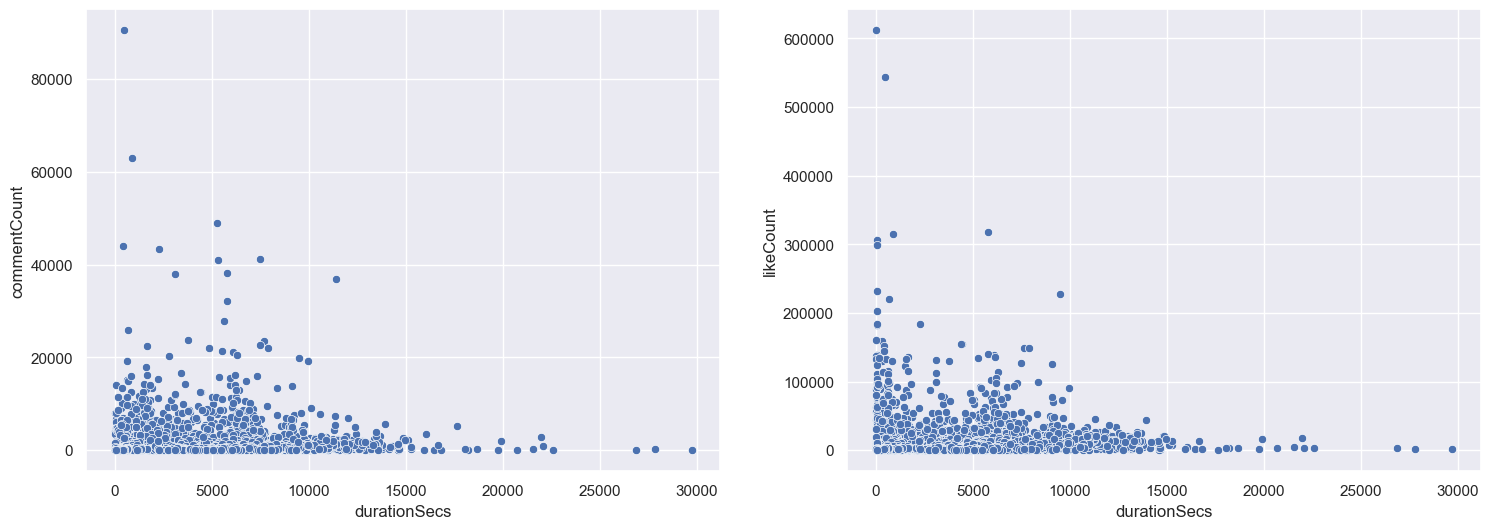

In [14]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<Axes: xlabel='titleLength', ylabel='viewCount'>

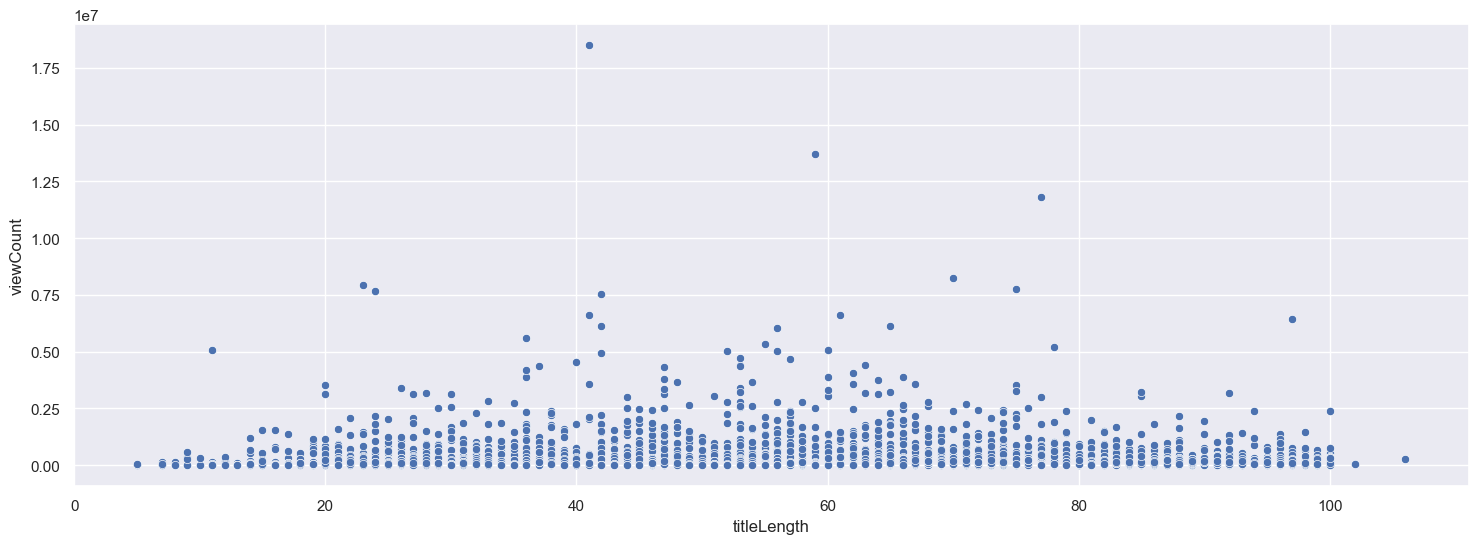

In [15]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


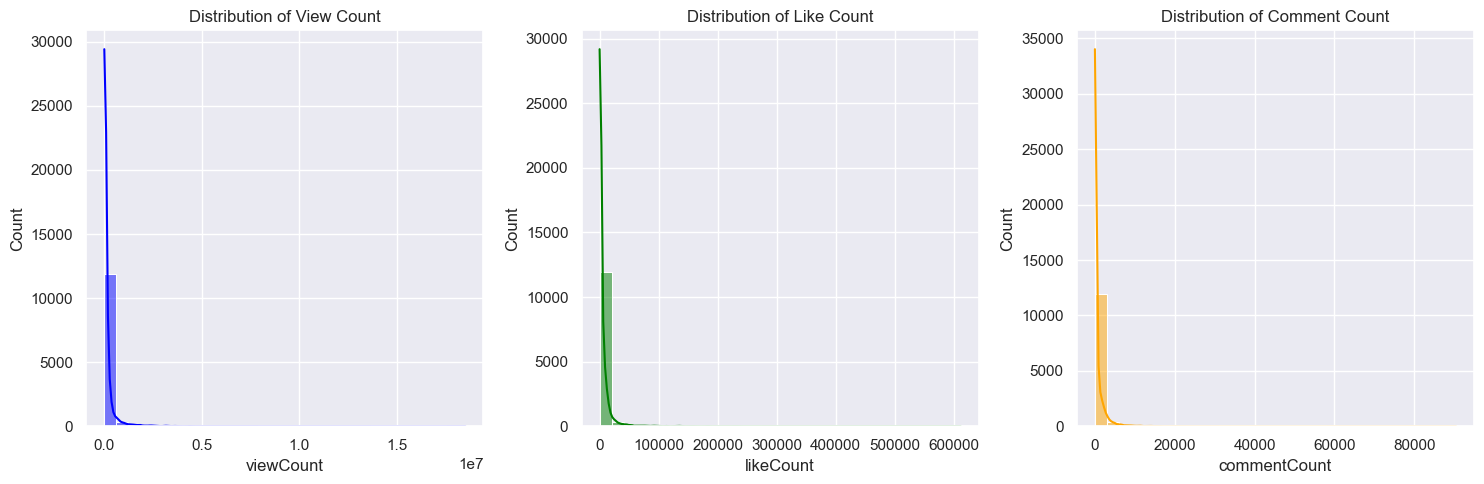

In [16]:
# Set up the figure
plt.figure(figsize=(15, 5))

# Plot histograms
plt.subplot(1, 3, 1)
sns.histplot(video_df['viewCount'], kde=True, bins=30, color='blue')
plt.title('Distribution of View Count')

plt.subplot(1, 3, 2)
sns.histplot(video_df['likeCount'], kde=True, bins=30, color='green')
plt.title('Distribution of Like Count')

plt.subplot(1, 3, 3)
sns.histplot(video_df['commentCount'], kde=True, bins=30, color='orange')
plt.title('Distribution of Comment Count')

plt.tight_layout()
plt.show()

/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


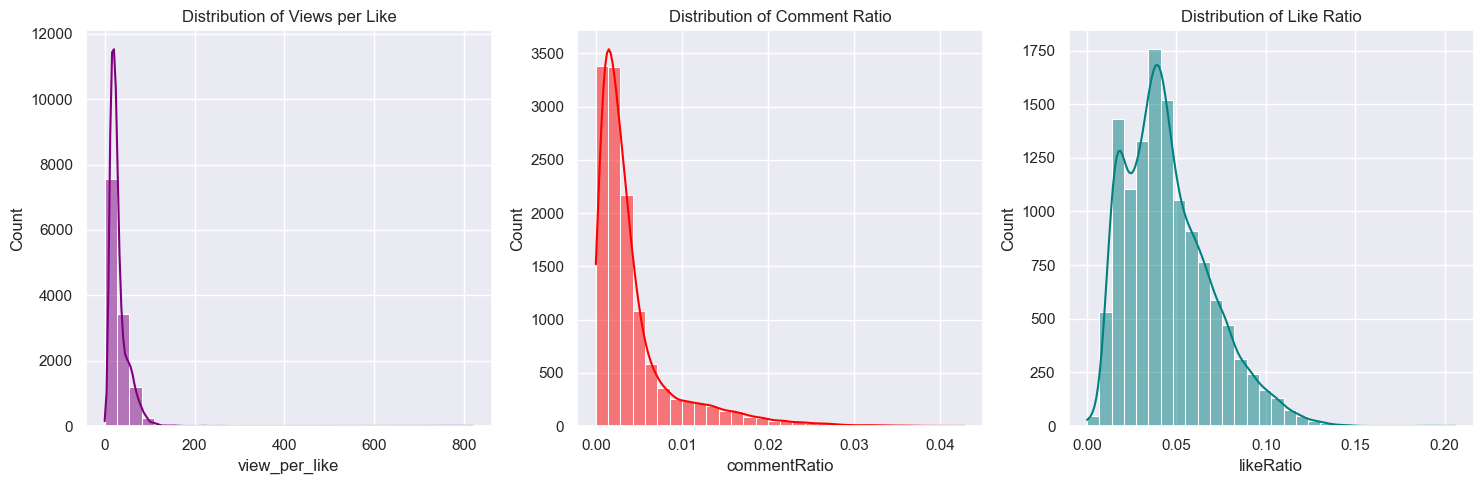

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(video_df['view_per_like'], kde=True, bins=30, color='purple')
plt.title('Distribution of Views per Like')

plt.subplot(1, 3, 2)
sns.histplot(video_df['commentRatio'], kde=True, bins=30, color='red')
plt.title('Distribution of Comment Ratio')

plt.subplot(1, 3, 3)
sns.histplot(video_df['likeRatio'], kde=True, bins=30, color='teal')
plt.title('Distribution of Like Ratio')

plt.tight_layout()
plt.show()

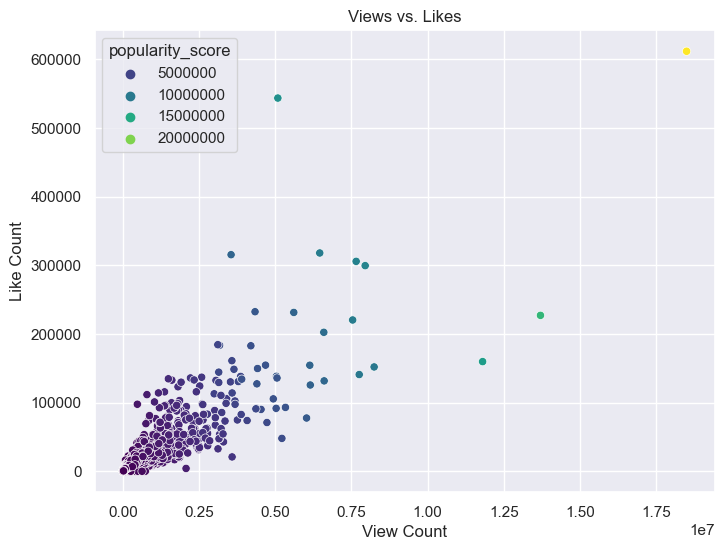

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='viewCount', y='likeCount', data=video_df, hue='popularity_score', palette='viridis')
plt.title('Views vs. Likes')
plt.xlabel('View Count')
plt.ylabel('Like Count')
plt.show()

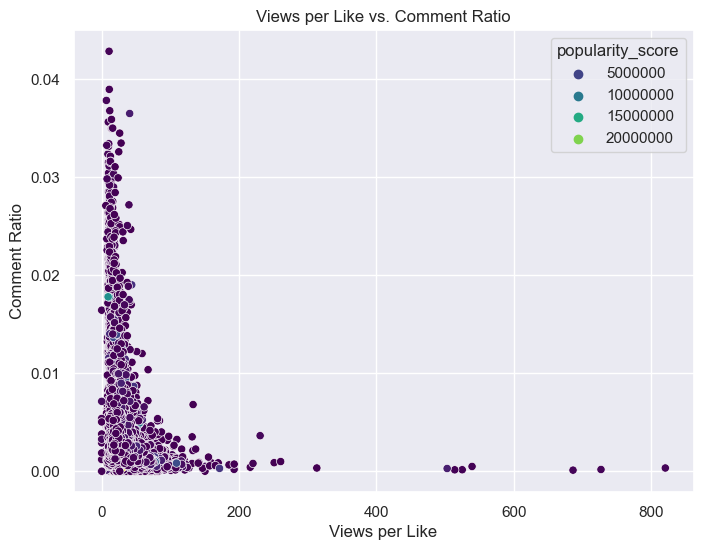

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='view_per_like', y='commentRatio', data=video_df, hue='popularity_score', palette='viridis')
plt.title('Views per Like vs. Comment Ratio')
plt.xlabel('Views per Like')
plt.ylabel('Comment Ratio')
plt.show()

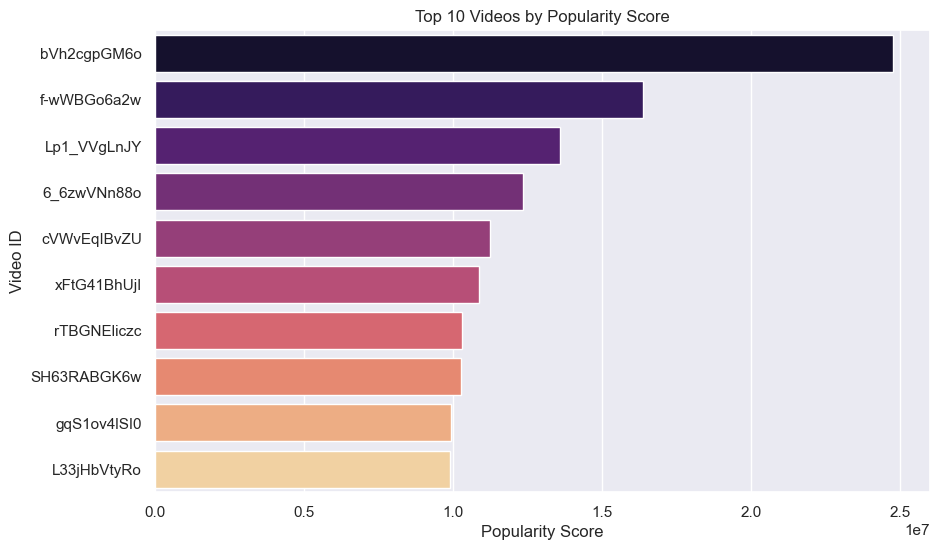

In [22]:
top_10_videos = video_df.nlargest(10, 'popularity_score')
plt.figure(figsize=(10, 6))
sns.barplot(x='popularity_score', y='video_id', data=top_10_videos, palette='magma')
plt.title('Top 10 Videos by Popularity Score')
plt.xlabel('Popularity Score')
plt.ylabel('Video ID')
plt.show()

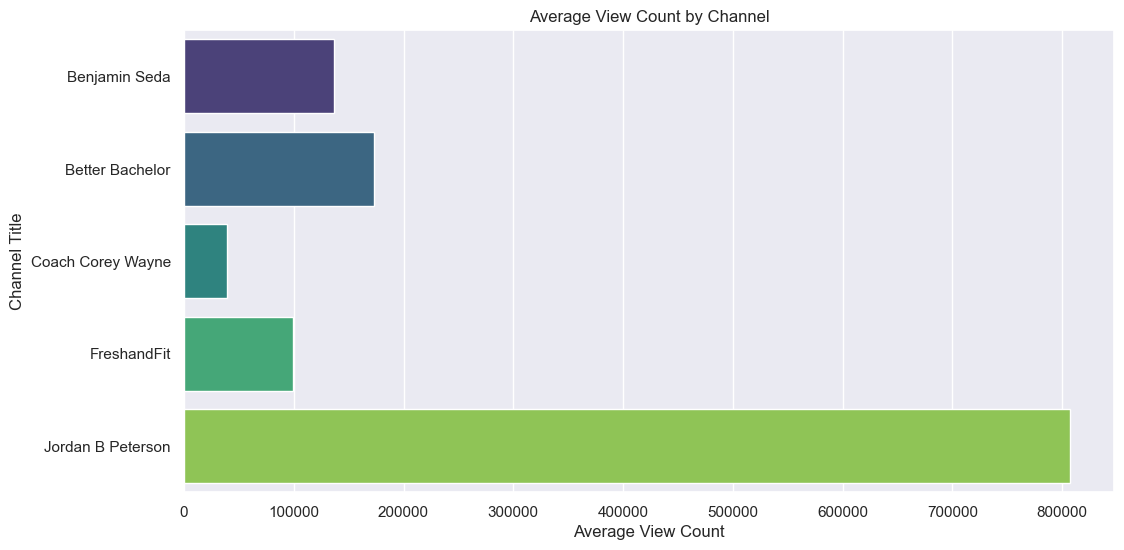

In [23]:
channel_metrics = video_df.groupby('channelTitle')[['viewCount', 'likeCount', 'commentCount']].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='viewCount', y='channelTitle', data=channel_metrics, palette='viridis')
plt.title('Average View Count by Channel')
plt.xlabel('Average View Count')
plt.ylabel('Channel Title')
plt.show()

/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bashaar/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

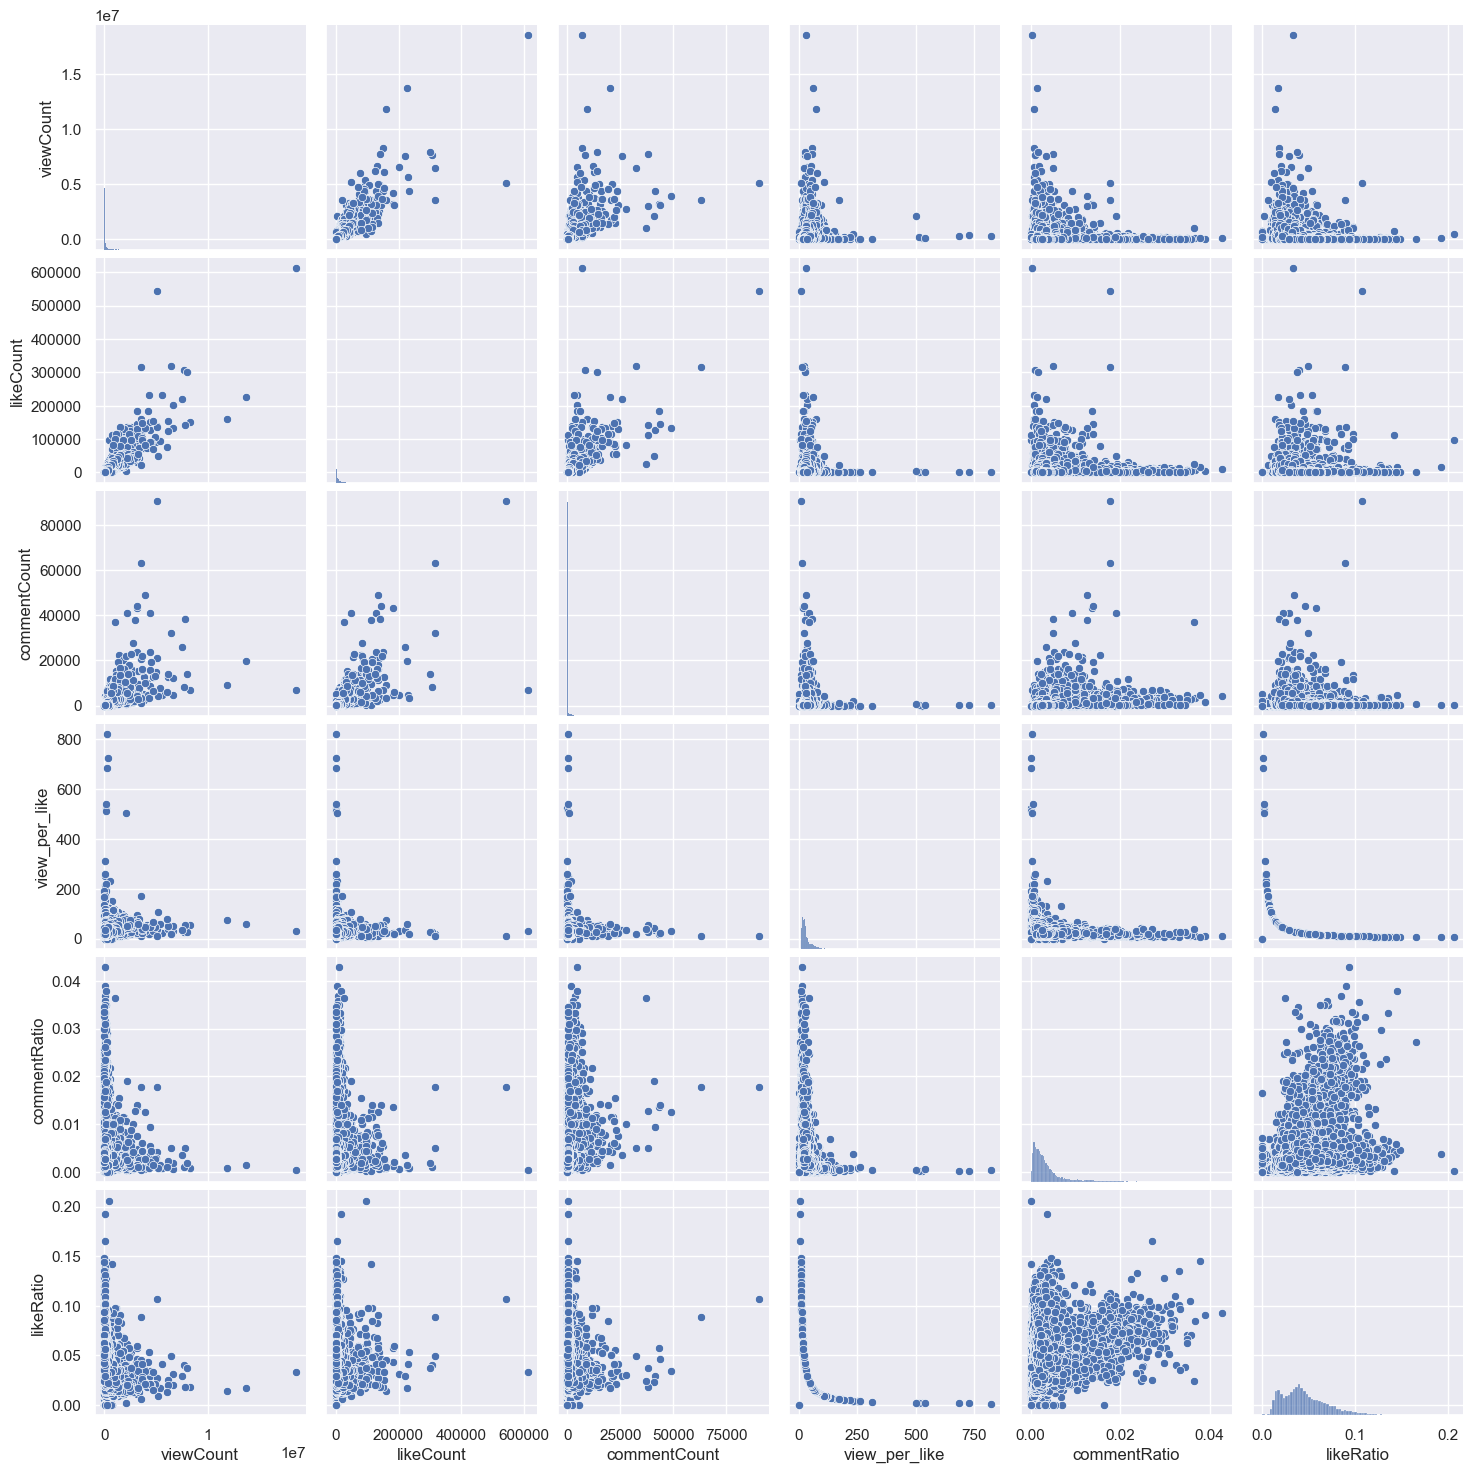

In [24]:
sns.pairplot(video_df[['viewCount', 'likeCount', 'commentCount', 'view_per_like', 'commentRatio', 'likeRatio']])
plt.show()

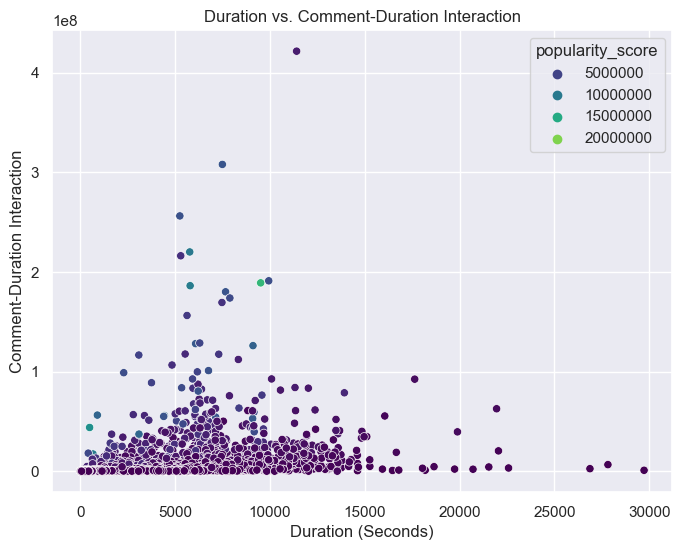

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='durationSecs', y='comment_duration_interaction', data=video_df, hue='popularity_score', palette='viridis')
plt.title('Duration vs. Comment-Duration Interaction')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Comment-Duration Interaction')
plt.show()

In [16]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

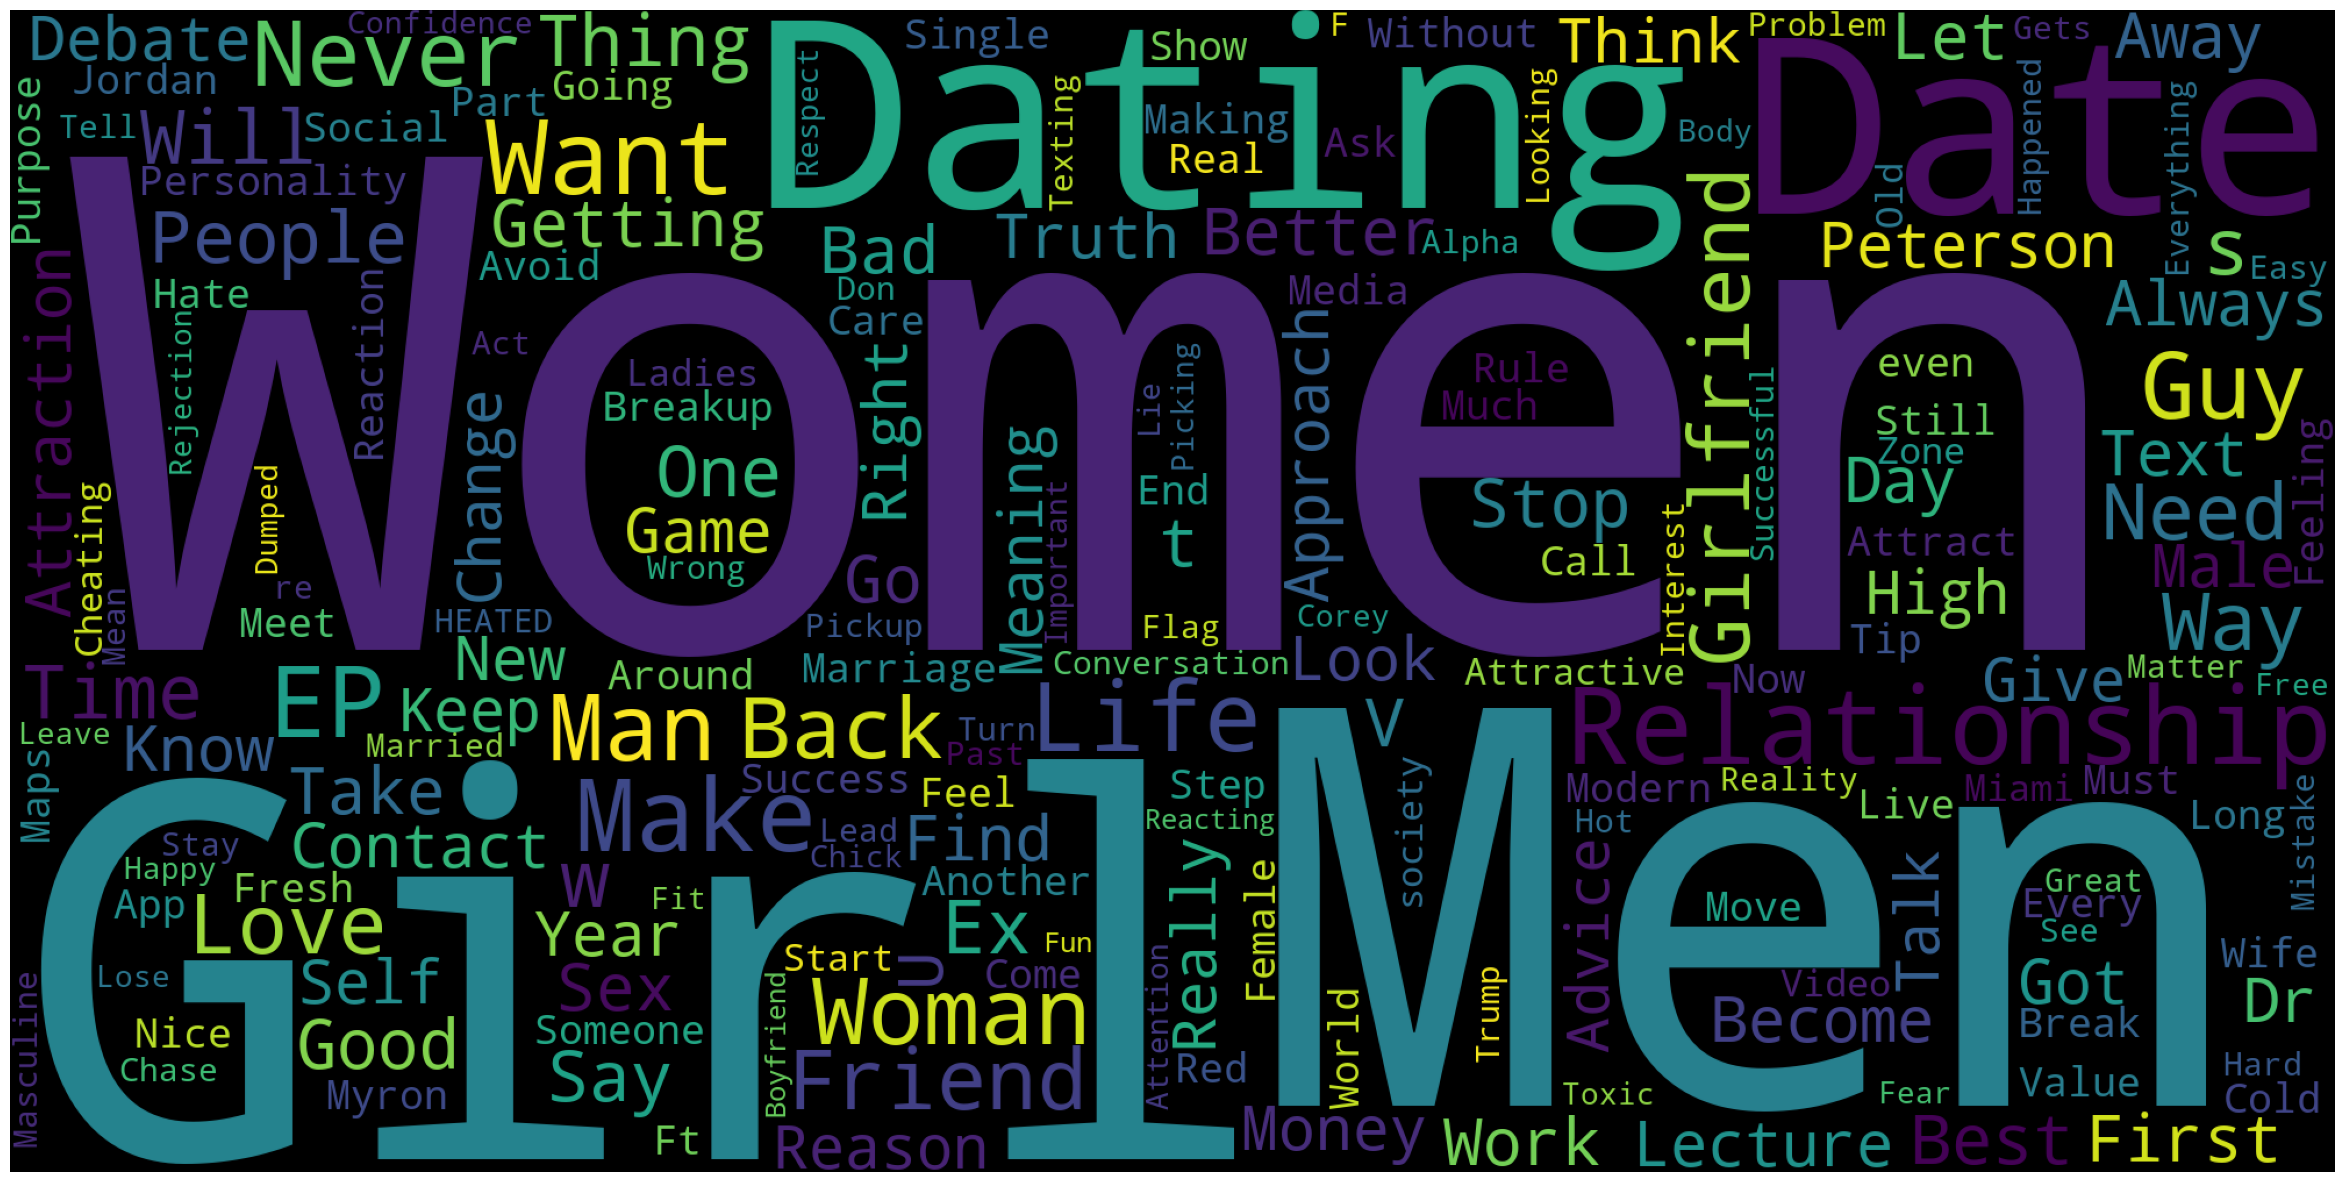

In [17]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

<Axes: xlabel='tagCount', ylabel='viewCount'>

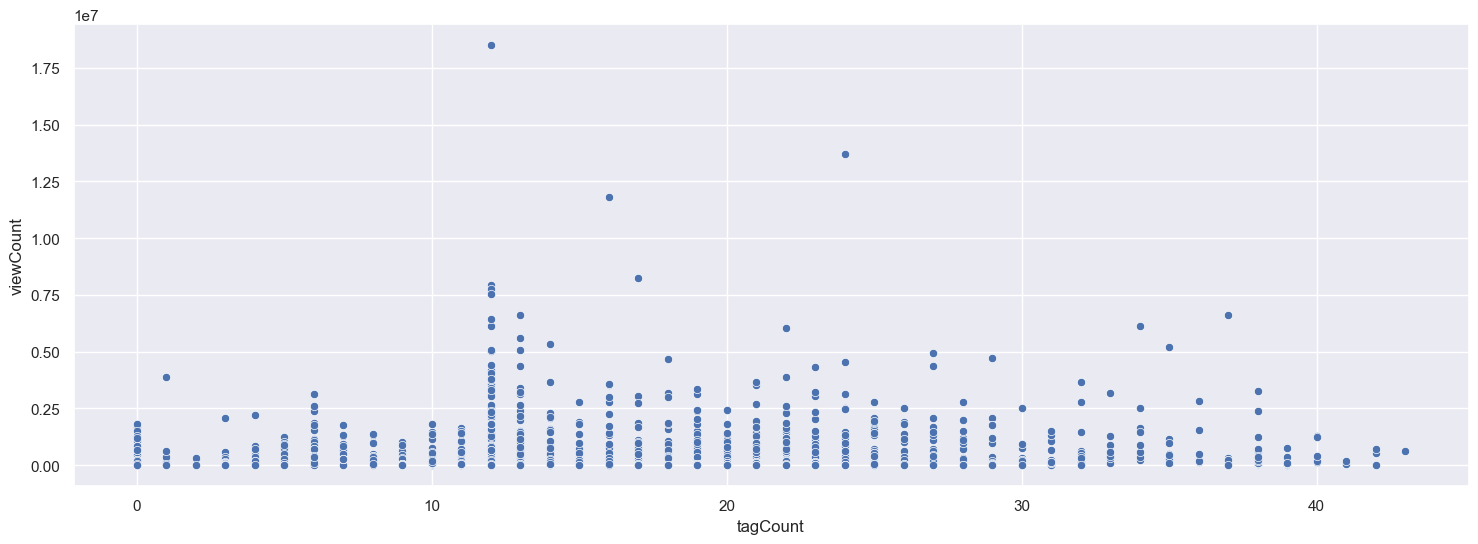

In [18]:
sns.scatterplot(data = video_df, x = "tagCount", y = "viewCount")

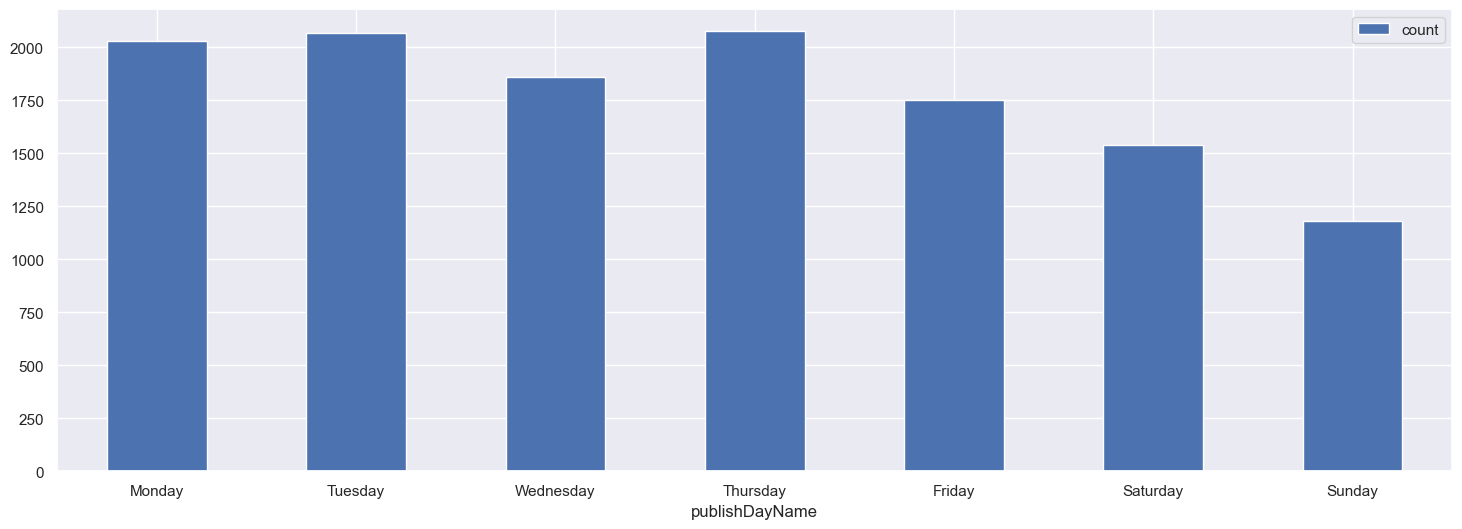

In [19]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
# Use 'pushblishDayName' as x and 'count' as y
ax = day_df.reset_index().plot.bar(x='publishDayName', y='count', rot=0)

In [20]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comment'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

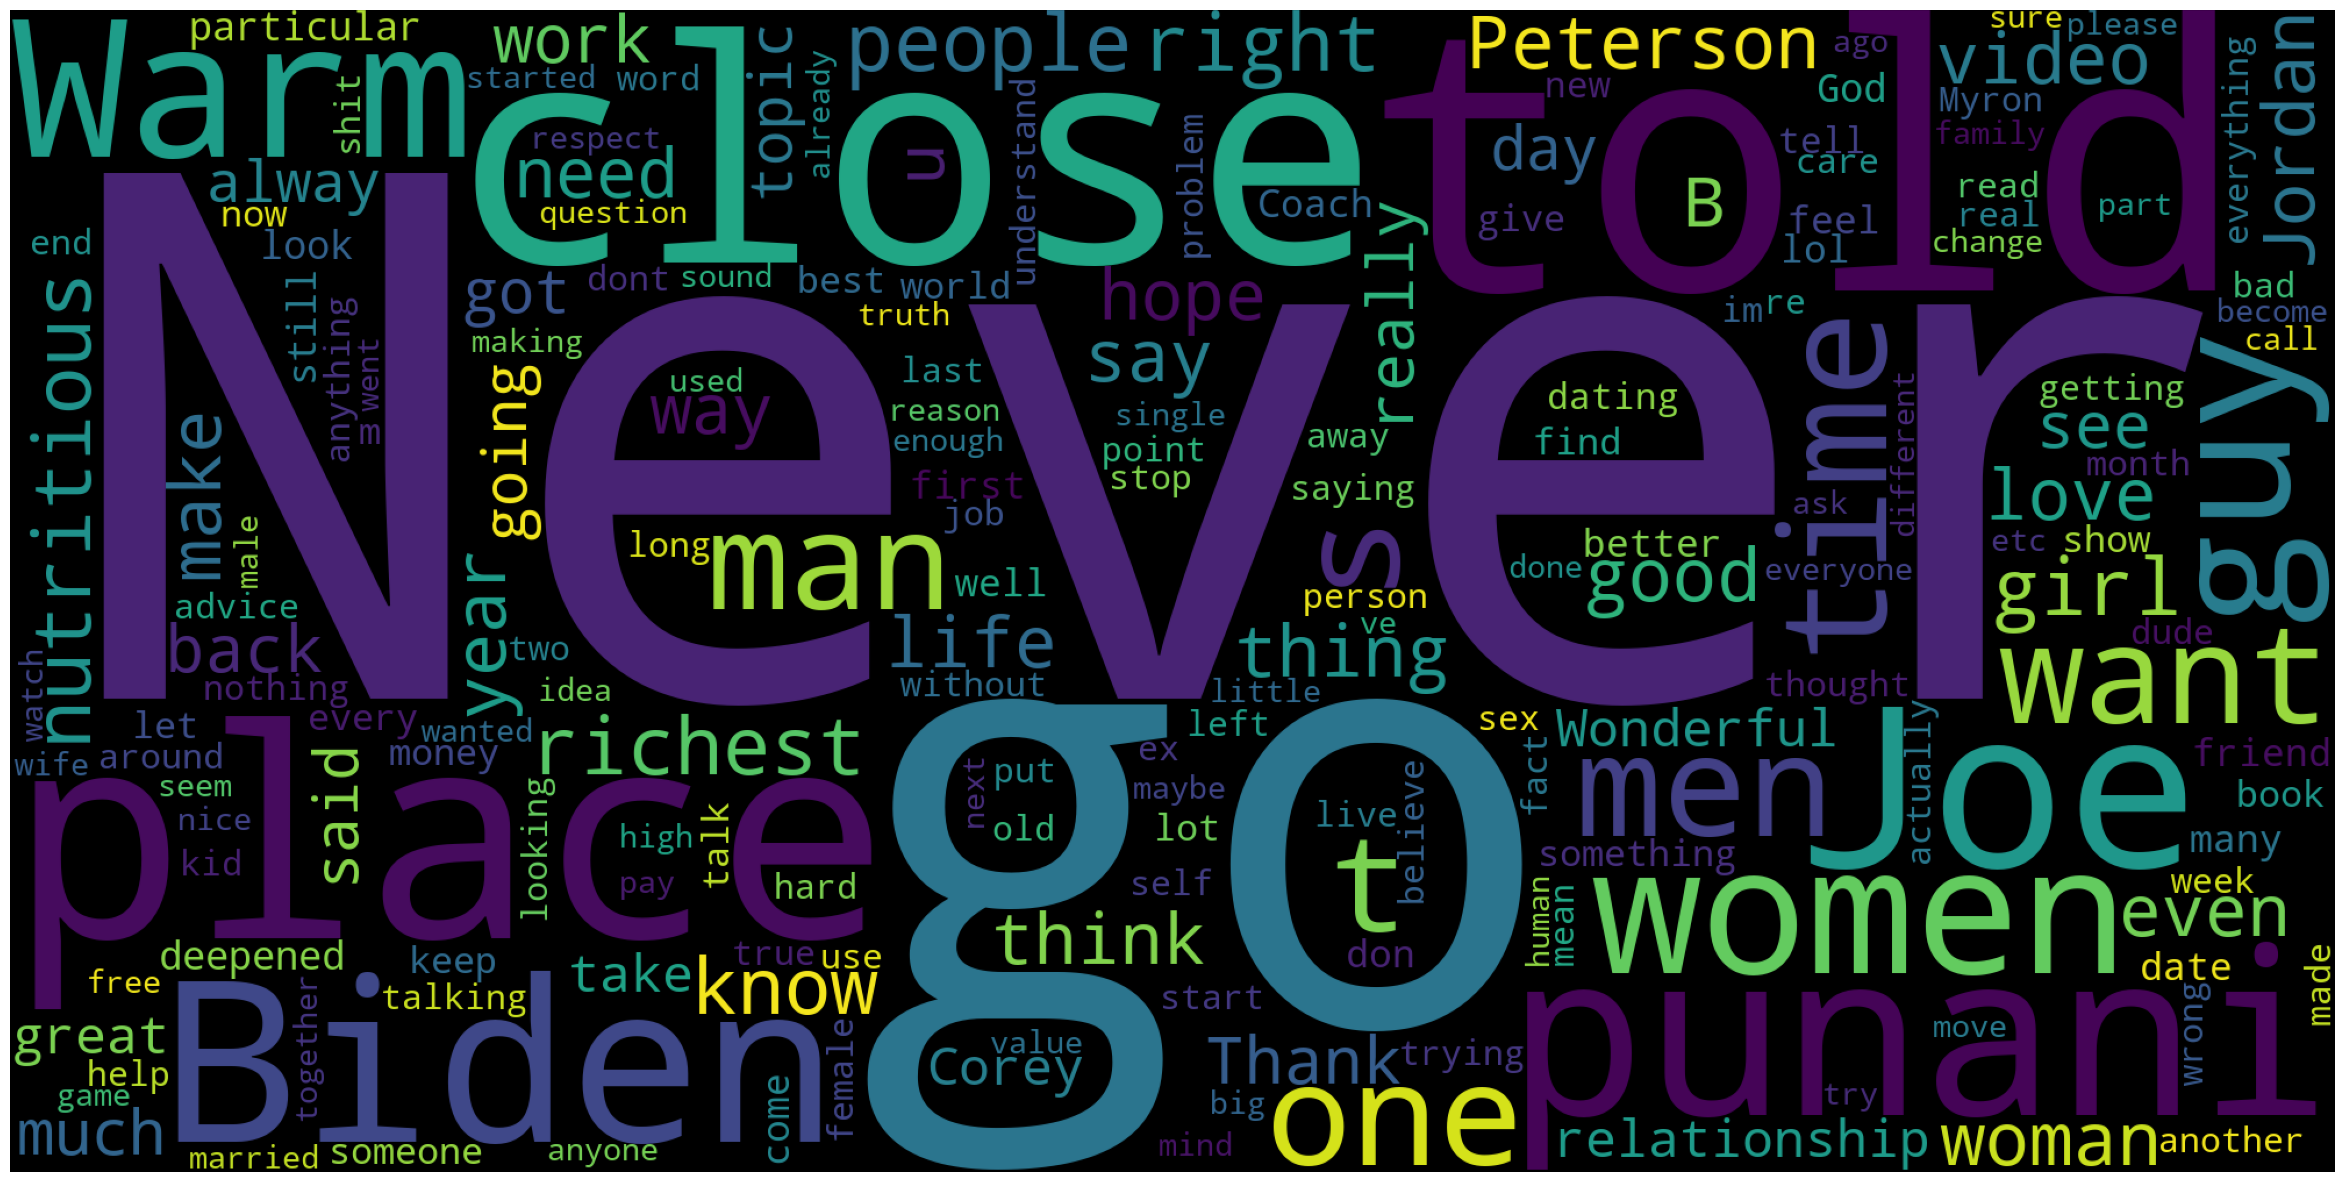

In [21]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)